<a href="https://colab.research.google.com/github/vjuge/oc-iml/blob/P6/modules/P6/module_P6_V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
from keras.utils.vis_utils import plot_model
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageShow
import cv2 as cv

import tensorflow as tf
from tensorflow import keras
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.vis_utils import plot_model
from keras import backend as K
from keras.models import load_model
from tensorflow.keras import layers

from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


In [2]:
device_name = tf.test.gpu_device_name()
if "GPU" not in device_name:
    print("GPU device not found")
else: print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


## Download Dataset

In [3]:

def load_dataset(display_summary=False, as_supervised=True) :
    """Return Train, Test datasets and related informations
    :return: 
    ds_train (tf.data.DataSet) The requested training dataset.
    ds_test (tf.data.DataSet) The requested test dataset.
    ds_info (tfds.core.DatasetInfo) The requested dataset info.
    """
    # https://www.tensorflow.org/datasets/catalog/stanford_dogs
    (ds_test, ds_val, ds_train), ds_info = tfds.load('stanford_dogs', 
                                                split=["test", "train[0%:20%]", "train[20%:]"], 
                                                shuffle_files=True, 
                                                as_supervised=as_supervised,
                                                with_info=True)
    assert isinstance(ds_train, tf.data.Dataset)
    if (display_summary): print(ds_info)
    return ds_train, ds_test, ds_val, ds_info


train_ds, test_ds, val_ds, ds_info = load_dataset(display_summary=True, as_supervised=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/stanford_dogs/0.2.0.incompleteNX265Q/stanford_dogs-train.tfrecord


  0%|          | 0/12000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/stanford_dogs/0.2.0.incompleteNX265Q/stanford_dogs-test.tfrecord


  0%|          | 0/8580 [00:00<?, ? examples/s]

Dataset stanford_dogs downloaded and prepared to /root/tensorflow_datasets/stanford_dogs/0.2.0. Subsequent calls will reuse this data.
tfds.core.DatasetInfo(
    name='stanford_dogs',
    version=0.2.0,
    description='The Stanford Dogs dataset contains images of 120 breeds of dogs from around
the world. This dataset has been built using images and annotation from
ImageNet for the task of fine-grained image categorization. There are
20,580 images, out of which 12,000 are used for training and 8580 for
testing. Class labels and bounding box annotations are provided
for all the 12,000 images.',
    homepage='http://vision.stanford.edu/aditya86/ImageNetDogs/main.html',
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'image/filename': Text(shape=(), dtype=tf.string),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=120),
        'objects': Sequence({
            'bbox': BBoxFeature(shape=(4,), dtype=tf.float32),
        }

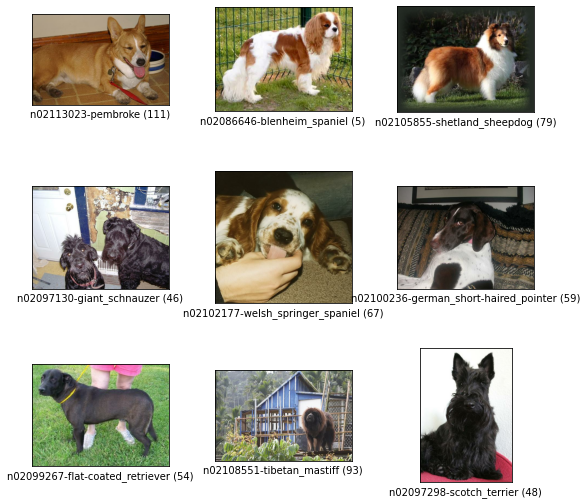

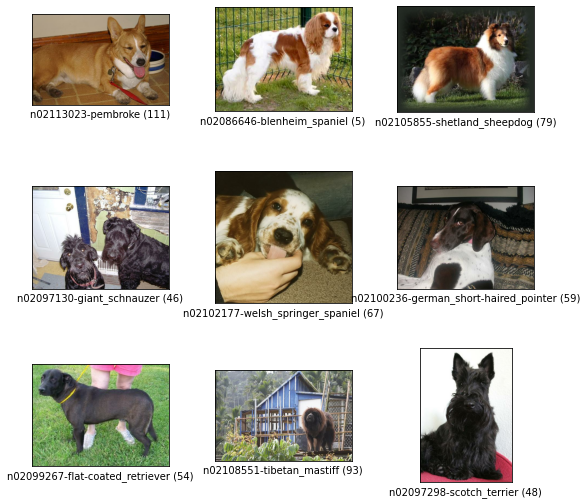

In [4]:
tfds.show_examples(train_ds, ds_info)

In [5]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(333, 500, 3)
()


In [6]:
# AUTOTUNE = tf.data.AUTOTUNE
# batch_size = 32

# train_ds = train_ds.cache().shuffle(1000).batch(batch_size).prefetch(buffer_size=AUTOTUNE)
# val_ds = val_ds.cache().batch(batch_size).prefetch(buffer_size=AUTOTUNE)

In [7]:
train_ds

<_OptionsDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [8]:
num_classes = ds_info.features['label'].num_classes
print(num_classes)

120


In [9]:
IMG_SIZE = 244

In [10]:
%pip install tensorflow_addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 8.2 MB/s 


## Model

In [33]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

Data augmentation:

<https://pyimagesearch.com/2019/07/08/keras-imagedatagenerator-and-data-augmentation/>


In [44]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(IMG_SIZE,
                                  IMG_SIZE,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomTranslation(0.2, 0.2)
  ]
)

In [11]:
from tensorflow_addons.image import mean_filter2d

batch_size = 32
AUTOTUNE = tf.data.AUTOTUNE

data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])

normalization_layer = layers.Rescaling(1./255)

def prepare(ds : tf.data.Dataset, shuffle=False, augment=False):

  ds = ds.map(lambda x, y: (normalization_layer(x), y))

  # filter dataset
  ds = ds.map(lambda x,y: (mean_filter2d(x), y),
            num_parallel_calls=AUTOTUNE)
  
  # Resize and rescale
#   ds = ds.map(lambda x, y: (resize_and_rescale(x), y), num_parallel_calls=AUTOTUNE)
  ds = ds.map(lambda x, y: (tf.image.resize_with_pad(x/255, IMG_SIZE, IMG_SIZE), y), num_parallel_calls=AUTOTUNE)

  if shuffle:
    ds = ds.shuffle(1000)

  ds = ds.cache()

  # Batch all datasets.
  ds = ds.batch(batch_size)

  # Use data augmentation only on the training set.
  if augment:
    ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), 
                num_parallel_calls=AUTOTUNE)

  # Use buffered prefetching on all datasets.
  return ds.prefetch(buffer_size=AUTOTUNE)   

In [23]:
ds = prepare(train_ds, shuffle=True, augment=True)
ds_val = prepare(val_ds)

In [24]:
ds
ds_val

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 244, 244, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 244, 244, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [39]:

model = Sequential([
    layers.InputLayer(input_shape=(IMG_SIZE, IMG_SIZE, 3)),
#   layers.Resizing(IMG_SIZE, IMG_SIZE, crop_to_aspect_ratio=True),
  layers.Rescaling(1./255),
#   layers.Reshape((IMG_SIZE, IMG_SIZE, 3)),
  
  # Convolution layer
  layers.Conv2D(filters=16,
                kernel_size=(3,3), 
                padding='same', 
                activation='relu'),
  layers.BatchNormalization(axis=3, scale=False),
  layers.Activation('relu'),

  # Pooling layer
  layers.MaxPooling2D(pool_size=(4,4),
                      strides=(4,4),
                    padding='same'),
  # Second convolution layer
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.BatchNormalization(axis=3, scale=False),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),   #add dropout for better performances

  # Third convolution layer
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.BatchNormalization(axis=3, scale=False),
  layers.GlobalAveragePooling2D(),
  
  # Fully connected layers
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, activation='softmax')
])


model.compile(optimizer='adam',
              loss="sparse_categorical_crossentropy",
              metrics=['accuracy', f1_m])

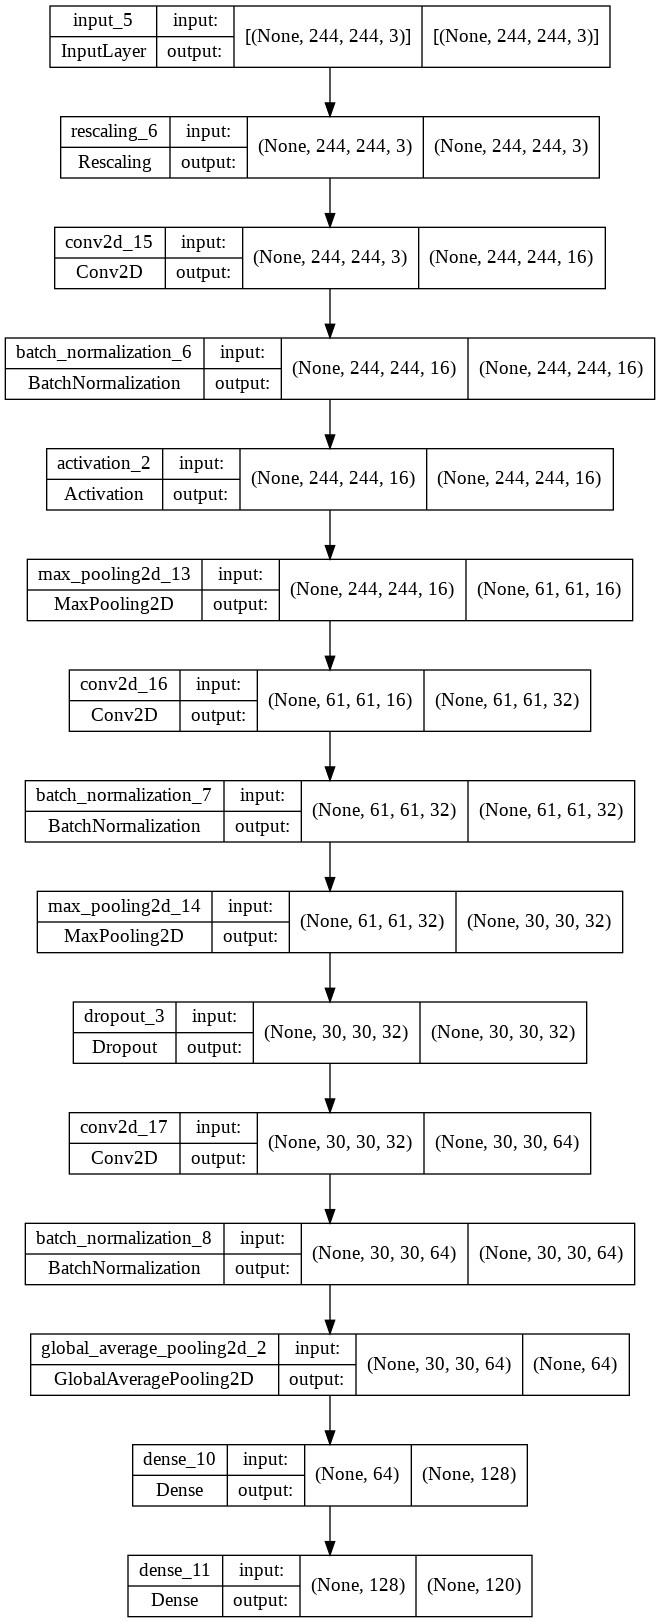

In [40]:
plot_model(model, show_shapes=True, show_layer_names=True)

In [41]:
model.build()

model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_6 (Rescaling)     (None, 244, 244, 3)       0         
                                                                 
 conv2d_15 (Conv2D)          (None, 244, 244, 16)      448       
                                                                 
 batch_normalization_6 (Batc  (None, 244, 244, 16)     48        
 hNormalization)                                                 
                                                                 
 activation_2 (Activation)   (None, 244, 244, 16)      0         
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 61, 61, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (None, 61, 61, 32)       

tip: in order to view GPU usage, type command: `watch -n 1 nvidia-smi`

In [42]:
epochs=15
history = model.fit(
  ds,
  validation_data=ds_val,
  epochs=epochs
)

Epoch 1/15
300/300 [==============================] - 65s 211ms/step - loss: 4.7855 - accuracy: 0.0095 - f1_m: 118.7842 - val_loss: 4.7966 - val_accuracy: 0.0063 - val_f1_m: 119.8925
Epoch 2/15
300/300 [==============================] - 71s 235ms/step - loss: 4.7623 - accuracy: 0.0130 - f1_m: 114.6648 - val_loss: 72.7398 - val_accuracy: 0.0079 - val_f1_m: 0.9964
Epoch 3/15
300/300 [==============================] - 65s 213ms/step - loss: 4.7356 - accuracy: 0.0149 - f1_m: 109.2171 - val_loss: 144.6689 - val_accuracy: 0.0096 - val_f1_m: 0.9964
Epoch 4/15
300/300 [==============================] - 64s 211ms/step - loss: 4.7250 - accuracy: 0.0157 - f1_m: 107.4956 - val_loss: 310.2562 - val_accuracy: 0.0083 - val_f1_m: 0.9964
Epoch 5/15
300/300 [==============================] - 64s 210ms/step - loss: 4.7156 - accuracy: 0.0165 - f1_m: 106.2246 - val_loss: 117.8424 - val_accuracy: 0.0096 - val_f1_m: 1.7771
Epoch 6/15
300/300 [==============================] - 64s 211ms/step - loss: 4.7129 - 

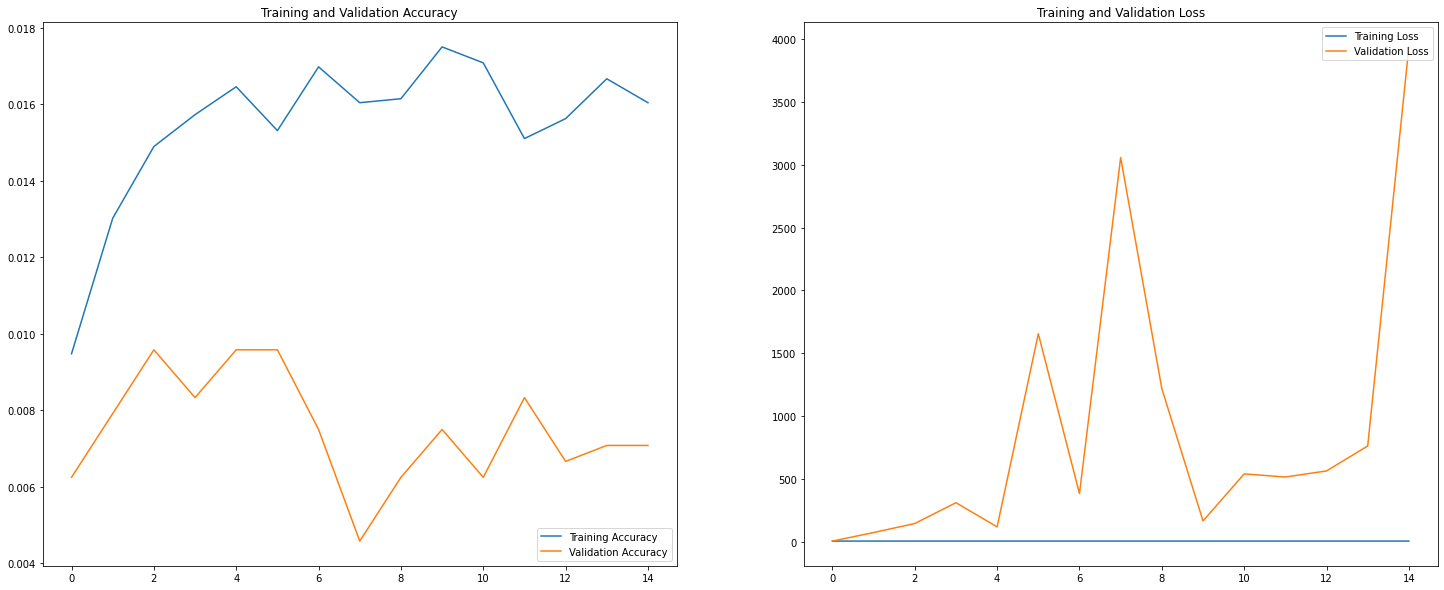

In [43]:
def show_accuracy_loss(history, epochs):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs_range = range(epochs)

  plt.figure(figsize=(25, 10))
  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, acc, label='Training Accuracy')
  plt.plot(epochs_range, val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')

  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.show()

show_accuracy_loss(history, epochs)

## Pre-trained model : Transfer Learning

### XCeption Model

In [45]:
K.clear_session()
# Import Xception trained model
xception_model = tf.keras.applications.xception.Xception(
    weights='imagenet',
    include_top=False, 
    pooling='avg',
    input_shape=(299,299,3))

# look at the differents layers
print("-" * 50)
print("Xception base model layers :")
print("-" * 50)
for layer in xception_model.layers:
    print(layer)

83697664/83683744 [==============================] - 1s 0us/step
--------------------------------------------------
Xception base model layers :
--------------------------------------------------


In [46]:
for layer in xception_model.layers:
    layer.trainable = False

In [48]:
# Add new fully-connected layers
base_output = xception_model.output
base_output = Dense(128, activation='relu')(base_output)
base_output = Dropout(0.2)(base_output)
# Output : new classifier
predictions = Dense(num_classes, activation='softmax')(base_output)

# Define new model
my_xcept_model = Model(inputs=xception_model.input,
                       outputs=predictions)
my_xcept_model.compile(optimizer="adam",
                       loss="sparse_categorical_crossentropy",
                       metrics=["accuracy", f1_m])

In [49]:
Xception_plot = plot_model(my_xcept_model,
                           show_shapes=True,
                           show_layer_names=False)

In [50]:
# Data generator on train set with Data Augmentation
# and preprocess_input Xception
# Validation set is define here
train_datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2,
    preprocessing_function=tf.keras.applications.xception.preprocess_input)

#For validation and test, just rescale
test_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.xception.preprocess_input)

In [51]:
history_xcept = my_xcept_model.fit(
    train_datagen.flow(
        x_train, y_train,
        batch_size=16,
        subset='training'),
    validation_data=train_datagen.flow(
        x_train, y_train,
        batch_size=16,
        subset='validation'),
    steps_per_epoch=len(x_train) / 32,
    epochs=20,
    verbose=2)

NameError: ignored